<a href="https://colab.research.google.com/github/yjucho1/tf_codes/blob/master/3%EC%A3%BC%EC%B0%A8_%EC%BD%94%EB%93%9C%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Better performance with the tf.data API

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf

import time

TensorFlow 2.x selected.


In [0]:
class ArtificialDataset(tf.data.Dataset):
    def _generator(num_samples):
        # Opening the file
        time.sleep(0.03)
        
        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            time.sleep(0.015)
            
            yield (sample_idx,)
    
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=tf.dtypes.int64,
            output_shapes=(1,),
            args=(num_samples,)
        )

In [0]:
def benchmark(dataset, num_epochs=2):
  start_time = time.perf_counter()
  for epoch_num in range(num_epochs):
    for sample in dataset:
      time.sleep(0.01)
  tf.print("Execution time:", time.perf_counter() - start_time)

In [0]:
## naive approach
benchmark(ArtificialDataset())

Execution time: 0.3285793459999695


In [0]:
## prefetching
benchmark(ArtificialDataset().prefetch(tf.data.experimental.AUTOTUNE))

Execution time: 0.19277315600004385


In [0]:
## parallelizing data extraction
### sequential interleave
benchmark(
    tf.data.Dataset.range(2).interleave(ArtificialDataset)
)

Execution time: 0.19699192899997797


In [0]:
## parallelizing data extraction
### parallel interleave
benchmark(
    tf.data.Dataset.range(2).interleave(ArtificialDataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
)

Execution time: 0.13689856299993153


In [0]:
## Parallelizing data transformation
def mapped_function(s):
  tf.py_function(lambda: time.sleep(0.03), [], ())
  return s

In [0]:
## Parallelizing data transformation
### Sequential mapping
benchmark(
    ArtificialDataset().map(mapped_function)
)

Execution time: 0.4215109689998826


In [0]:
## Parallelizing data transformation
### Parallel mapping
benchmark(
    ArtificialDataset().map(mapped_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
)

Execution time: 0.28764794900007473


In [0]:
## Caching
benchmark(
    ArtificialDataset().map(mapped_function).cache(),5
)

Execution time: 0.36404495500005396


In [0]:
## Vectorizing mapping
fast_dataset = tf.data.Dataset.range(10000)

def fast_benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for _ in tf.data.Dataset.range(num_epochs):
        for _ in dataset:
            pass
    tf.print("Execution time:", time.perf_counter() - start_time)
    
def increment(x):
    return x+1

In [0]:
fast_benchmark(
    fast_dataset
    # Apply function one item at a time
    .map(increment)
    # Batch
    .batch(256)
)

In [0]:
fast_benchmark(
    fast_dataset
    .batch(256)
    # Apply function on a batch of items
    # The tf.Tensor.__add__ method already handle batches
    .map(increment)
)

In [0]:
dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)


In [0]:
import itertools
from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters)
    OUTPUT_TYPES = (tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32)
    OUTPUT_SHAPES = ((2, 1), (2, 2), (2, 3))
    
    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset
    
    def _generator(instance_idx, num_samples):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])
        
        # Opening the file
        open_enter = time.perf_counter()
        time.sleep(0.03)
        open_elapsed = time.perf_counter() - open_enter
        
        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            time.sleep(0.015)
            read_elapsed = time.perf_counter() - read_enter
            
            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered
            
    
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(next(cls._INSTANCES_COUNTER), num_samples)
        )

In [0]:
(
  [("Open"), ("Read")],
  [(t0, d), (t0, d)],
  [(i, e, -1), (i, e, s)]
)

In [0]:
def timelined_benchmark(dataset, num_epochs=2):
    # Initialize accumulators
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)
    
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        epoch_enter = time.perf_counter()
        for (steps, times, values) in dataset:
            # Record dataset preparation informations
            steps_acc = tf.concat((steps_acc, steps), axis=0)
            times_acc = tf.concat((times_acc, times), axis=0)
            values_acc = tf.concat((values_acc, values), axis=0)
            
            # Simulate training time
            train_enter = time.perf_counter()
            time.sleep(0.01)
            train_elapsed = time.perf_counter() - train_enter
            
            # Record training informations
            steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
            times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
            values_acc = tf.concat((values_acc, [values[-1]]), axis=0)
        
        epoch_elapsed = time.perf_counter() - epoch_enter
        # Record epoch informations
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch_num, -1]]), axis=0)
        time.sleep(0.001)
    
    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [0]:
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()
    
    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)
    
    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")
        
        # Get timings and annotation for the given step
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]
        
        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

In [0]:
def map_decorator(func):
    def wrapper(steps, times, values):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values),
            Tout=(steps.dtype, times.dtype, values.dtype)
        )
    return wrapper

In [0]:
_batch_map_num_items = 50

def dataset_generator_fun(*args):
    return TimeMeasuredDataset(num_samples=_batch_map_num_items)

In [0]:
@map_decorator
def naive_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001)  # Time contumming step
    time.sleep(0.0001)  # Memory consumming step
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0)
    )

naive_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .flat_map(dataset_generator_fun)
    .map(naive_map)
    .batch(_batch_map_num_items, drop_remainder=True)
    .unbatch(),
    5
)

In [0]:
@map_decorator
def time_consumming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001 * values.shape[0])  # Time contumming step
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, tf.tile([[["1st map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )


@map_decorator
def memory_consumming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.0001 * values.shape[0])  # Memory consumming step
    map_elapsed = time.perf_counter() - map_enter

    # Use tf.tile to handle batch dimension
    return (
        tf.concat((steps, tf.tile([[["2nd map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )


optimized_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .interleave(  # Parallelize data reading
        dataset_generator_fun,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(  # Vectorize your mapped function
        _batch_map_num_items,
        drop_remainder=True)
    .map(  # Parallelize map transformation
        time_consumming_map,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .cache()  # Cache data
    .map(  # Reduce memory usage
        memory_consumming_map,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .prefetch(  # Overlap producer and consumer works
        tf.data.experimental.AUTOTUNE
    )
    .unbatch(),
    5
)

In [0]:
draw_timeline(naive_timeline, "Naive", 15)


In [0]:
draw_timeline(optimized_timeline, "Optimized", 15)


#Time serires forecasting

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [0]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [0]:
df = pd.read_csv(csv_path)

In [0]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [0]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  
  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  
  return np.array(data), np.array(labels)

In [0]:
TRAIN_SPLIT = 300000

In [0]:
tf.random.set_seed(13)

In [0]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a3804d470>],
      dtype=object)

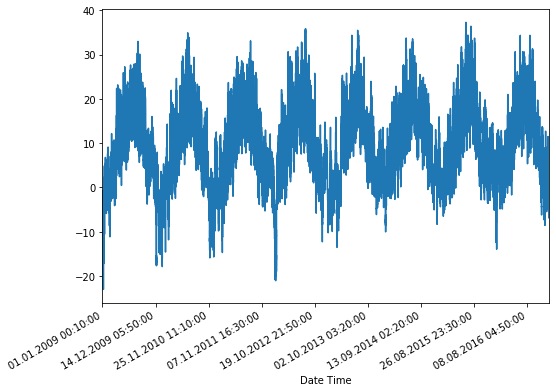

In [0]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                           univariate_past_history,
                                           univariate_future_target)


In [0]:
print('Single window of past history')
print(x_train_uni[0])
print('\n Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta :
    future = delta
  else :
    future =0
  
  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

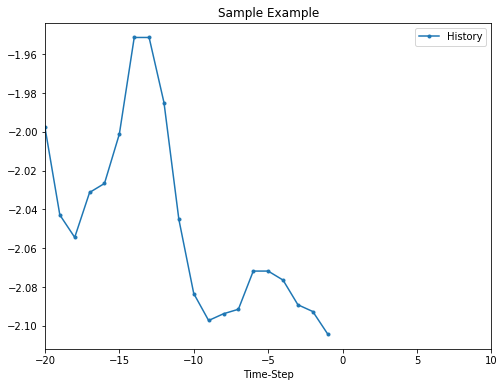

In [0]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

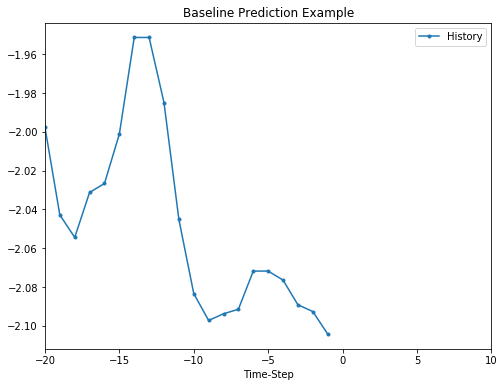

In [0]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
          'Baseline Prediction Example')

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
      tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [0]:
for x, y in val_univariate.take(1):
  print(simple_lstm_model.predict(x).shape)

(256, 1)


In [0]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)


Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 22ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0262 - val_loss: 0.0196
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0253 - val_loss: 0.0182
Epoch 10/10
200/200 [===========================

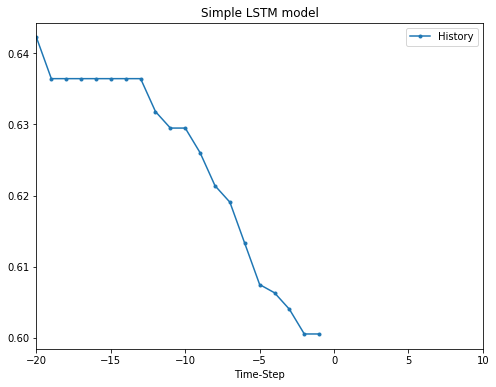

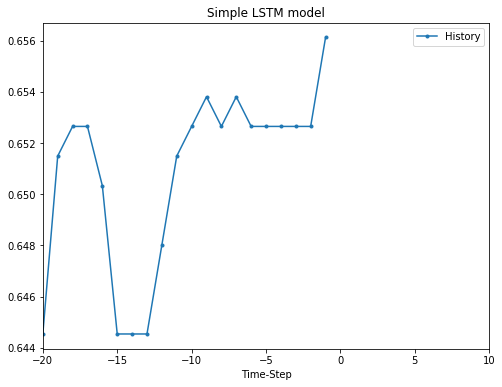

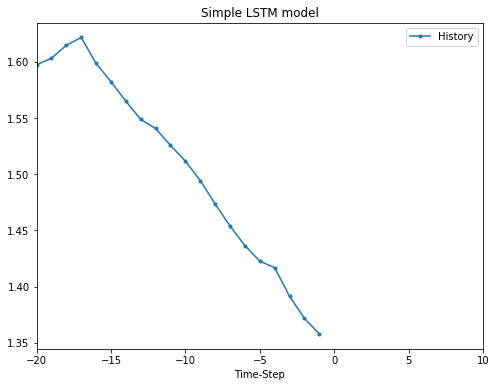

In [0]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), x[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  
  plot.show()
  

In [0]:
### multivariate
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [0]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a26199860>,
      dtype=object)

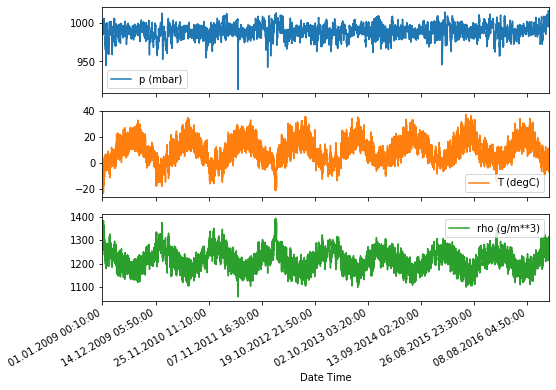

In [0]:
features.plot(subplots=True)

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [0]:
dataset = (dataset-data_mean) / data_std

In [0]:
### single step model

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i - history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else :
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels) 

In [0]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                                   TRAIN_SPLIT, None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)


In [0]:
print('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (120, 3)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, 
                                  input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')


In [0]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [0]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 27s 137ms/step - loss: 0.3355 - val_loss: 0.2722
Epoch 2/10
200/200 [==============================] - 25s 126ms/step - loss: 0.2660 - val_loss: 0.2408
Epoch 3/10
200/200 [==============================] - 27s 136ms/step - loss: 0.2603 - val_loss: 0.2385
Epoch 4/10
200/200 [==============================] - 27s 135ms/step - loss: 0.2575 - val_loss: 0.2398
Epoch 5/10
200/200 [==============================] - 26s 131ms/step - loss: 0.2277 - val_loss: 0.2342
Epoch 6/10
200/200 [==============================] - 26s 132ms/step - loss: 0.2398 - val_loss: 0.2522
Epoch 7/10
200/200 [==============================] - 27s 135ms/step - loss: 0.2427 - val_loss: 0.2548
Epoch 8/10
200/200 [==============================] - 27s 136ms/step - loss: 0.2428 - val_loss: 0.2436
Epoch 9/10
200/200 [==============================] - 27s 136ms/step - loss: 0.2459 - val_loss: 0.2395
Epoch 10/10
200/200 [=========

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.show()

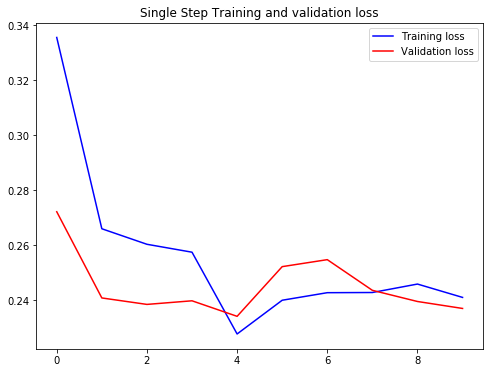

In [0]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

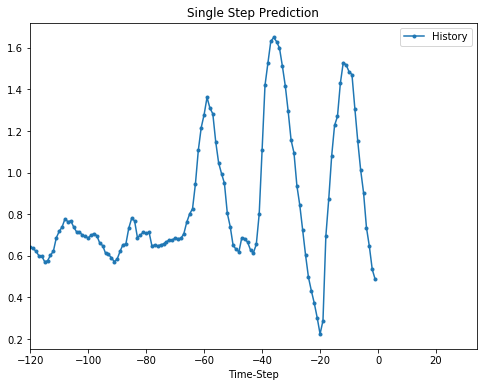

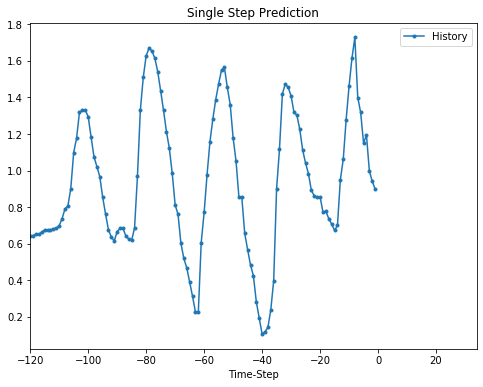

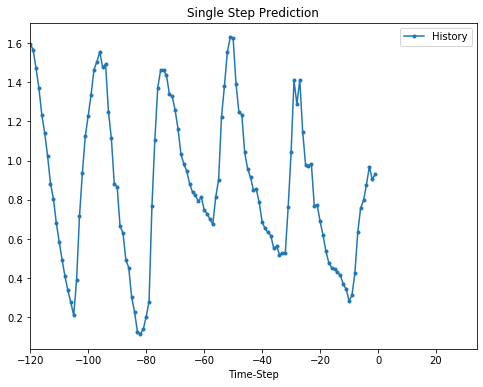

In [0]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:,1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [0]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                                 TRAIN_SPLIT, None, past_history,
                                                 future_target, STEP)


In [0]:
print('Single window of past history : {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

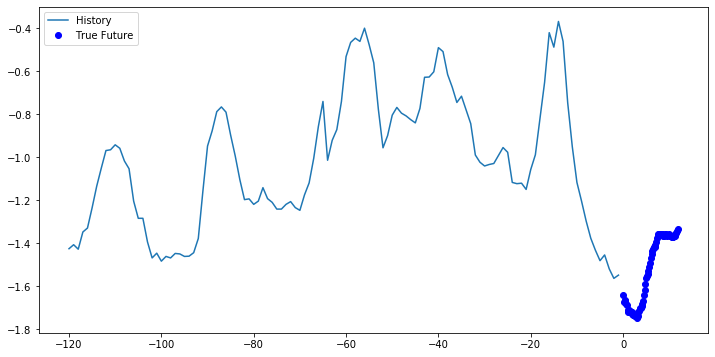

In [0]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, 
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))


multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [0]:
for x, y in val_data_multi.take(1):
  print(multi_step_model.predict(x).shape)

(256, 72)


In [0]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)


Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 49s 246ms/step - loss: 35.4583 - val_loss: 0.3043
Epoch 2/10
200/200 [==============================] - 46s 229ms/step - loss: 0.3417 - val_loss: 0.2792
Epoch 3/10
200/200 [==============================] - 48s 238ms/step - loss: 0.3272 - val_loss: 0.2455
Epoch 4/10
200/200 [==============================] - 47s 237ms/step - loss: 0.2416 - val_loss: 0.2037
Epoch 5/10
200/200 [==============================] - 47s 234ms/step - loss: 0.1976 - val_loss: 0.2034
Epoch 6/10
200/200 [==============================] - 47s 235ms/step - loss: 0.2059 - val_loss: 0.2129
Epoch 7/10
200/200 [==============================] - 48s 242ms/step - loss: 0.1986 - val_loss: 0.2119
Epoch 8/10
200/200 [==============================] - 48s 242ms/step - loss: 0.1957 - val_loss: 0.1967
Epoch 9/10
200/200 [==============================] - 49s 247ms/step - loss: 0.1989 - val_loss: 0.1904
Epoch 10/10
200/200 [========

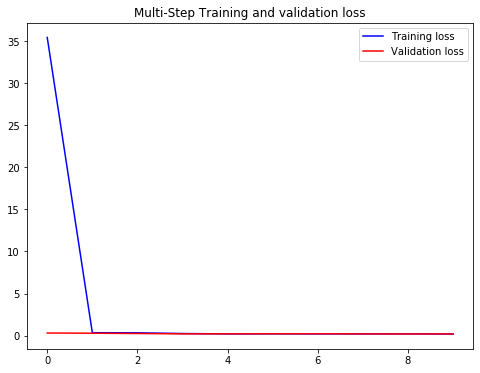

In [0]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

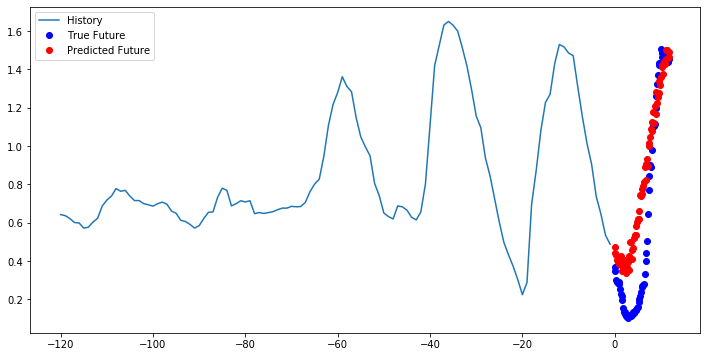

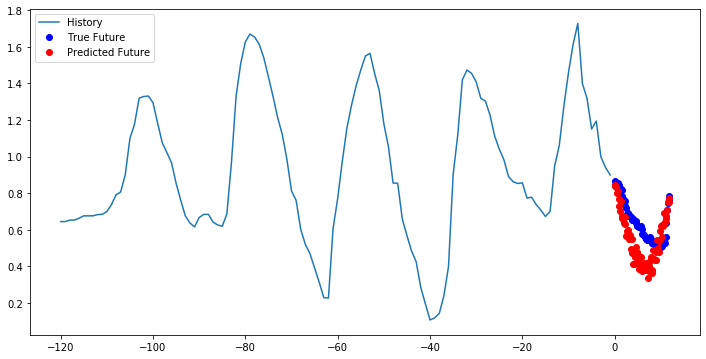

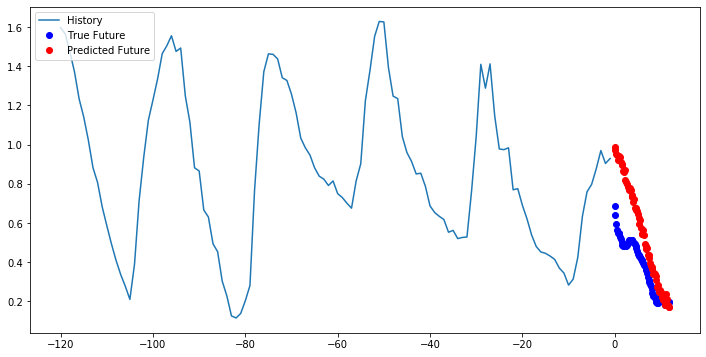

In [0]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

# Text classification with an RNN

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow_datasets as tfds
import tensorflow as tf

     |████████████████████████████████| 516.6MB 32kB/s 
     |████████████████████████████████| 2.9MB 35.1MB/s 
     |████████████████████████████████| 2.8MB 30.2MB/s 
     |████████████████████████████████| 460kB 44.4MB/s 
     |████████████████████████████████| 778kB 53.0MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2


In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [0]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                           as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']


In [0]:
encoder = info.features['text'].encoder

In [0]:
print('Vocabulary size : {}'.format(encoder.vocab_size))

Vocabulary size : 8185


In [0]:
sample_string = 'Hello TensorFlow'

encoded_string = encoder.encode(sample_string)
print('Ecoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The orginal string: {}'.format(original_string))

Ecoded string is [4025, 222, 6307, 2327, 4043, 2120]
The orginal string: Hello TensorFlow


In [0]:
assert original_string == sample_string

In [0]:
for index in encoded_string:
  print('{}  --->  {}'.format(index, encoder.decode([index])))

4025  --->  Hell
222  --->  o 
6307  --->  Ten
2327  --->  sor
4043  --->  Fl
2120  --->  ow


In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [0]:
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/2
391/391 [==============================] - 905s 2s/step - loss: 0.1579 - accuracy: 0.9442 - val_loss: 0.3968 - val_accuracy: 0.8641
Epoch 2/2
391/391 [==============================] - 908s 2s/step - loss: 0.1440 - accuracy: 0.9500 - val_loss: 0.3945 - val_accuracy: 0.8630


In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    317/Unknown - 165s 522ms/step - loss: 0.3487 - accuracy: 0.8657

KeyboardInterrupt: ignored

In [0]:
def pred_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sample_pred_text, pred):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cat(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [0]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

In [0]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

In [0]:
plot_graphs(history, 'accuracy')

In [0]:
plot_graphs(history, 'loss')

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [0]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [0]:
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

In [0]:
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

In [0]:
plot_graphs(history, 'accuracy')

In [0]:
plot_graphs(history, 'loss')

# Distributed training with Keras

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  !pip install tf-nightly
except Exception:
  pass

import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()

import os


     |████████████████████████████████| 516.6MB 21kB/s 
     |████████████████████████████████| 2.8MB 29.9MB/s 
     |████████████████████████████████| 2.9MB 27.0MB/s 
     |████████████████████████████████| 460kB 47.2MB/s 
     |████████████████████████████████| 778kB 50.0MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


In [0]:
print(tf.__version__)

2.2.0-dev20200227


In [0]:
datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)

mnist_train, mnist_test = datasets['train'], datasets['test']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [0]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [0]:
print('number of devices: {}'.format(strategy.num_replicas_in_sync))

number of devices: 1


In [0]:
# You can also do info.splits.total_num_examples to get the total
# number of examples in the dataset.

num_train_examples = info.splits['train'].num_examples
num_test_example = info.splits['test'].num_examples

BUFFER_SIZE = 10000

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [0]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255

  return image, label

In [0]:
train_dataset = mnist_train.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
eval_dataset = mnist_test.map(scale).batch(BATCH_SIZE)

In [0]:
with strategy.scope():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10)
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [0]:
# Define the checkpoint directory to store the checkpoints

checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [0]:
# Function for decaying the learning rate.
# You can define any decay function you need.

def decay(epoch):
  if epoch < 3 :
    return 1e-3
  elif epoch >= 3 and epoch < 7:
    return 1e-4
  else :
    return 1e-5


In [0]:
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1, 
                                                      model.optimizer.lr.numpy()))
    

In [0]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [0]:
model.fit(train_dataset, epochs=12, callbacks=callbacks)

Epoch 1/12
    936/Unknown - 33s 35ms/step - accuracy: 0.9422 - loss: 0.1974
Learning rate for epoch 1 is 0.0010000000474974513
938/938 [==============================] - 33s 35ms/step - accuracy: 0.9423 - loss: 0.1972 - lr: 0.0010
Epoch 2/12
937/938 [============================>.] - ETA: 0s - accuracy: 0.9811 - loss: 0.0636
Learning rate for epoch 2 is 0.0010000000474974513
938/938 [==============================] - 33s 36ms/step - accuracy: 0.9811 - loss: 0.0636 - lr: 0.0010
Epoch 3/12
937/938 [============================>.] - ETA: 0s - accuracy: 0.9864 - loss: 0.0448
Learning rate for epoch 3 is 0.0010000000474974513
938/938 [==============================] - 33s 35ms/step - accuracy: 0.9864 - loss: 0.0448 - lr: 0.0010
Epoch 4/12
936/938 [============================>.] - ETA: 0s - accuracy: 0.9936 - loss: 0.0243
Learning rate for epoch 4 is 9.999999747378752e-05
938/938 [==============================] - 33s 35ms/step - accuracy: 0.9936 - loss: 0.0242 - lr: 1.0000e-04
Epoch 5/12


In [0]:
# check the checkpoint directory
!ls {checkpoint_dir}

checkpoint		     ckpt_4.data-00000-of-00001
ckpt_10.data-00000-of-00001  ckpt_4.index
ckpt_10.index		     ckpt_5.data-00000-of-00001
ckpt_11.data-00000-of-00001  ckpt_5.index
ckpt_11.index		     ckpt_6.data-00000-of-00001
ckpt_12.data-00000-of-00001  ckpt_6.index
ckpt_12.index		     ckpt_7.data-00000-of-00001
ckpt_1.data-00000-of-00001   ckpt_7.index
ckpt_1.index		     ckpt_8.data-00000-of-00001
ckpt_2.data-00000-of-00001   ckpt_8.index
ckpt_2.index		     ckpt_9.data-00000-of-00001
ckpt_3.data-00000-of-00001   ckpt_9.index
ckpt_3.index


In [0]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

eval_loss, eval_acc = model.evaluate(eval_dataset)

print('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

157/157 [==============================] - 4s 24ms/step - accuracy: 0.9871 - loss: 0.0366
Eval loss: 0.03664407879114151, Eval Accuracy: 0.9871000051498413


In [0]:
!ls -sh ./logs

total 4.0K
4.0K train


In [0]:
path ='saved_model/'

In [0]:
model.save(path, save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [0]:
unreplicated_model = tf.keras.models.load_model(path)

unreplicated_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

eval_loss, eval_acc = unreplicated_model.evaluate(eval_dataset)

print('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

157/157 [==============================] - 4s 24ms/step - loss: 0.0366 - accuracy: 0.9871
Eval loss: 0.03664407879114151, Eval Accuracy: 0.9871000051498413


In [0]:
with strategy.scope():
  replicated_model = tf.keras.models.load_model(path)
  replicated_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

  eval_loss, eval_acc = replicated_model.evaluate(eval_dataset)
  print ('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

157/157 [==============================] - 4s 23ms/step - accuracy: 0.9871 - loss: 0.0366
Eval loss: 0.03664407879114151, Eval Accuracy: 0.9871000051498413
